In [ ]:
import timeit
import os
import math                                                 # basic calculations like square root
import numpy as np                                          # arrays and matrix math
import scipy.stats as st                                    # statistical methods
import matplotlib.pyplot as plt                             # for plotting
import geostatspy.GSLIB as GSLIB                            # GSLIB utilies, visualization and wrapper
import seaborn as sns
import pandas as pd              
from sklearn.neighbors import KNeighborsRegressor           # for nearest k neighbours
from sklearn import metrics                                 # measures to check our models
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.ensemble import BaggingRegressor   
from sklearn.ensemble import RandomForestRegressor          # random forest method
from sklearn.model_selection import KFold

def bagging_knn (seeds,x,y,xx,yy,num_k):
    bagging_models = []; 
    index = 1
    regressor = KNeighborsRegressor(weights = 'distance', n_neighbors=num_k, p = 2) 
    for seed in seeds:                                          # loop over random number seeds
        bagging_models.append(BaggingRegressor(base_estimator=regressor, n_estimators=1,random_state=seed, bootstrap=True, n_jobs = -1))
        bagging_models[index-1].fit(X = x , y = y)
        index = index + 1      
    index = 1
    for seed in seeds:                                       
        if index == 1:
            z = bagging_models[0].predict(np.c_[xx.ravel(), yy.ravel()])
            z = z.reshape(xx.shape)
        else:
            z_t = bagging_models[index-1].predict(np.c_[xx.ravel(), yy.ravel()])
            z_t = z_t.reshape(xx.shape)
            z = z + z_t                 
        index = index + 1
    z = z / len(seeds)
    ''' ## Edge Trimming
    i = 0
    while i < xx.shape[0]:
        j = 0
        while j < xx.shape[1]:
            L1 = np.min( euclidean_distances(x,[[xx[i,j],yy[i,j]]]) ) # get L1 to N-Neighbors
            if L1 > 0.5e5:
                z[i,j] = np.nan;
            j += 1
        i += 1 
        
    '''
    return z,bagging_models
##############################################################################################
def plot_bag_knn (xx,yy,z,prodmax,prodmin,max_num_bags,well_x,well_y,well_z):
    plt.figure(figsize=(11,7))
    cmap = plt.cm.RdYlBu_r
    cs = plt.contourf(xx, yy, z, cmap=cmap,vmin=prodmin, vmax=prodmax, levels=np.linspace(prodmin, prodmax, 100))
    plt.ticklabel_format(style='sci', scilimits=(0,0))
    cbar = plt.colorbar(cs, orientation = 'vertical',format='%.0e')
    cbar.set_label(PARA_3+' (bbl)', rotation=270, labelpad=20)
    plt.title('Oil EUR Trend - Aggregation of %i KNN Realizations'%max_num_bags,fontsize=14)
    plt.xlabel('West-East, Relative Location',fontsize=10); 
    plt.ylabel('North-South, Relative Location',fontsize=10)
    plt.xlim(xmin,xmax); plt.ylim(ymin,ymax);
    plt.ticklabel_format(style='sci', scilimits=(0,0))  
def plot_bag_knn_accuracy(df,bagging_models1,x,seeds,PARA_3): 
    bagging_models = bagging_models1
    index = 1
    z = []
    for seed in seeds:                                          # loop over random number seeds
        if index == 1:
            z = bagging_models[0].predict(x)
        else:
            z_t = bagging_models[index-1].predict(x)
            z = z + z_t
        index = index + 1
    predict = z / len(seeds)
    plt.figure(figsize=(6,4))
    plt.scatter(df[PARA_3],predict,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=0.1, verts=None, edgecolors="black")
    plt.suptitle('Model Check KNN with Bagging '); plt.xlabel('Actual Oil EUR'); plt.ylabel('Estimated Oil EUR')
    plt.xlim(0,6e5); plt.ylim(0,6e5)
    plt.arrow(0,0,6e5,6e5,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(df[PARA_3],predict)
    Var_Explained = metrics.explained_variance_score(df[PARA_3],predict)
    cor = math.sqrt(metrics.r2_score(df[PARA_3],predict))
    plt.title('MSE = %.2f, VE = %.2f, R^2 = %.2f' %(round(MSE,2),round(Var_Explained,2), round(cor,2)),fontsize=10)
    plt.ticklabel_format(style='sci', scilimits=(0,0))
    return 
def plot_bag_knn_return_predictions(df,bagging_models1,x,seeds,PARA_3): 
    bagging_models = bagging_models1
    index = 1
    z = []
    for seed in seeds:                                          # loop over random number seeds
        if index == 1:
            z = bagging_models[0].predict(x)
        else:
            z_t = bagging_models[index-1].predict(x)
            z = z + z_t
        index = index + 1
    predict = z / len(seeds)
    return predict
##############################################################################################  
def bagging_knn_KFold (seeds,x,y,xx,num_k):
    # x:train location; y:EUR; XX:test location
    bagging_models = []; 
    index = 1
    regressor = KNeighborsRegressor(weights = 'distance', n_neighbors=num_k, p = 2) 
    for seed in seeds:                                          # loop over random number seeds
        bagging_models.append(BaggingRegressor(base_estimator=regressor, n_estimators=1,random_state=seed, bootstrap=True, n_jobs = -1))
        bagging_models[index-1].fit(X = x , y = y)
        index = index + 1      
    index = 1
    for seed in seeds:                                       
        if index == 1:
            z = bagging_models[0].predict(xx)
        else:
            z_t = bagging_models[index-1].predict(xx)
            z = z + z_t                 
        index = index + 1
    z = z / len(seeds)
    return z
def my_kfold_cross_validation(X,Y,num_k,num_fold):
    kf = KFold(n_splits=num_fold,shuffle=True, random_state=77777)
    VE = []; MSE =[]
    index_fold = 1
    for train_index, test_index in kf.split(X):
        # each looping cycle is 1 fold
        z1 = []; bagging_models1 = []
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        z1 = bagging_knn_KFold (seeds,X_train,Y_train,X_test,num_k)
        VE.append(metrics.explained_variance_score(Y_test,z1))
        MSE.append(metrics.mean_squared_error(Y_test,z1))
        index_fold += 1    
    return np.average(VE),np.average(MSE)
def view_eurs( EUR,x_0,y_0,bubble_size,title,color):
    bubble = EUR/np.max(EUR)*bubble_size
    scatter = plt.scatter(x_0, y_0, bubble,c=color, alpha=0.3)
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    plt.xlabel("West-East", fontsize=10)
    plt.ylabel("North-South", fontsize=10)
    plt.title(title, fontsize=12,fontweight ="bold");
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    plt.grid(linestyle=':')
    plt.xlim(x_end_low, x_end_up)
    plt.ylim(y_end_low, y_end_up)

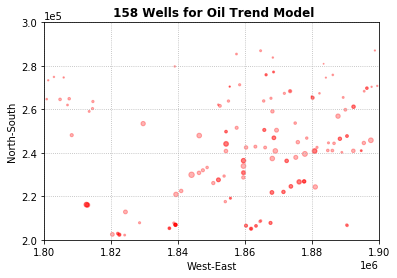

In [1]:
data_path = "Data/"
plot_path = "Plot/"
df = pd.read_csv(data_path+'01_Trend_Model_Oil.csv')
PARA_1 = 'x';    PARA_2 = 'y';   PARA_3 = 'Oil_EUR'

y_end_low = 2e5;    y_end_up = 3e5;
x_end_low = 1.8e6;  x_end_up = 1.8e6+1e5;

df =df[df['y']<y_end_up]
df =df[ df['y']>y_end_low]
df =df[df['x']>x_end_low ]
df =df[df['x']<x_end_up]

df.to_csv(data_path+'02_Kriging_Oil.csv',index = False)
df = pd.read_csv(data_path+'02_Kriging_Oil.csv')

prodmax = np.max(df[PARA_3]);        prodmin = np.min(df[PARA_3])
xmin = np.min(df[PARA_1]);           xmax = np.max(df[PARA_1]); 
ymin = np.min(df[PARA_2]);           ymax = np.max(df[PARA_2])
xx, yy = np.meshgrid(np.linspace(x_end_low, x_end_up, num=101),
                     np.linspace(y_end_low, y_end_up, num=101))

ini_k = 5;  max_k = 10;  increment_k = 2;  
linespace_k = np.arange(ini_k,max_k,increment_k)

bubble_size = 30
view_eurs(df['Oil_EUR'],df['x'],df['y'],bubble_size,
          ' %i Wells for Oil Trend Model'%df['Oil_EUR'].count(),'red')

In [2]:
num_fold = 8
X = np.c_[df[PARA_1],df[PARA_2]];    Y = df[PARA_3]      
bag = 1;      max_bags = 100
seed_start = 77077
VE_bags = []; MSE_bags =[]

for num_k in linespace_k :
    bag = 1;
    while bag <= max_bags:
        seeds = np.arange(seed_start, seed_start+bag, 1)
        VE,MSE = my_kfold_cross_validation(X,Y,num_k,num_fold)
        VE_bags.append(VE)    
        MSE_bags.append(MSE)  
        bag += 1  
    
VE_bags = pd.DataFrame(VE_bags)
MSE_bags = pd.DataFrame(MSE_bags)
VE_bags.to_csv(data_path+'ForKirg_Oil_Trend_Num_Bags_8Fold_VE.csv',index=False)
MSE_bags.to_csv(data_path+'ForKirg_Oil_Trend_Num_Bags_8Fold_MSE.csv',index=False)

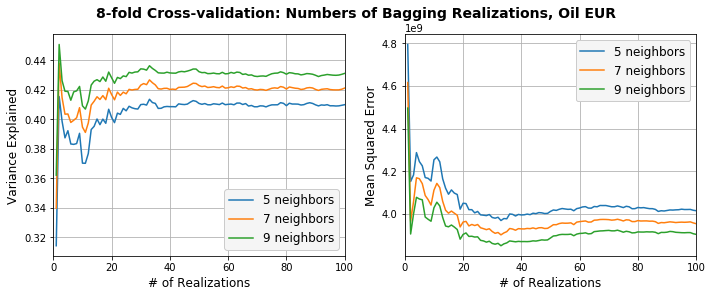

In [3]:
fig, ((ax1,ax2)) = plt.subplots(1, 2,figsize=(10, 4))

VE_bags = pd.read_csv(data_path+'ForKirg_Oil_Trend_Num_Bags_8Fold_VE.csv')
MSE_bags= pd.read_csv(data_path+'ForKirg_Oil_Trend_Num_Bags_8Fold_MSE.csv')
linespace_bags = np.arange(1, 101, 1)

index = 0
for k in linespace_k:
    DC = 'C'+str(index)
    ax1.plot(linespace_bags,VE_bags[0+index*100:100+index*100],color=DC,
             label = '%i neighbors'%k)
    ax2.plot(linespace_bags,MSE_bags[0+index*100:100+index*100],color=DC,
             label = '%i neighbors'%k)
    index += 1
    
ax1.legend(loc='lower right',framealpha=1,fontsize=12,facecolor='whitesmoke')
ax1.set_xlim(0,max_bags); 
ax1.set_xlabel('# of Realizations',fontsize=12);
ax1.set_ylabel('Variance Explained',fontsize=12);
ax1.grid()
ax2.set_xlim(0,max_bags); 
ax2.legend(loc='upper right',framealpha=1,fontsize=12,facecolor='whitesmoke')
ax2.set_xlabel('# of Realizations',fontsize=12);
ax2.set_ylabel('Mean Squared Error',fontsize=12);
ax2.grid()
fig.suptitle('8-fold Cross-validation: Numbers of Bagging Realizations, Oil EUR',fontweight='bold',y=1.02,fontsize=14);
fig.tight_layout()

In [4]:
bag = 50;

num_fold = 8
X = np.c_[df[PARA_1],df[PARA_2]];    Y = df[PARA_3]      

seed_start = 77077
VE_K = []; MSE_K =[]

ini_k = 1;  max_k = 31;  increment_k = 1;  
linespace_k =  np.arange(ini_k,max_k,increment_k)

for num_k in linespace_k :
    start_time = timeit.default_timer()   
    seeds = np.arange(seed_start, seed_start+bag, 1)
    VE,MSE = my_kfold_cross_validation(X,Y,num_k,num_fold)
    VE_K.append(VE)    
    MSE_K.append(MSE)  
    bag += 1   
VE_K = pd.DataFrame(VE_K)
MSE_K = pd.DataFrame(MSE_K)
VE_K.to_csv(data_path+'ForKirg_Oil_Trend_Num_neighbor_8Fold_VE.csv',index=False)
MSE_K.to_csv(data_path+'ForKirg_Oil_Trend_Num_neighbor_8Fold_MSE.csv',index=False)

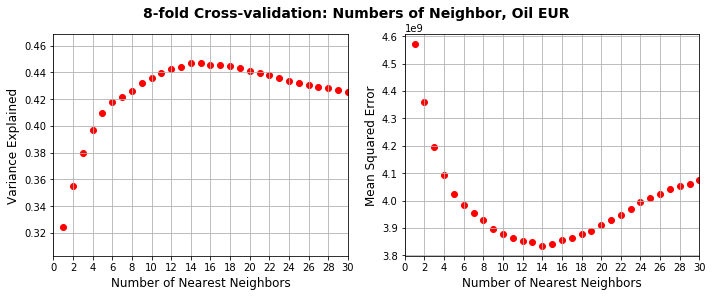

In [5]:
VE_K = pd.read_csv(data_path+'ForKirg_Oil_Trend_Num_neighbor_8Fold_VE.csv')
MSE_K= pd.read_csv(data_path+'ForKirg_Oil_Trend_Num_neighbor_8Fold_MSE.csv')

fig, ((ax1,ax2)) = plt.subplots(1, 2,figsize=(10, 4))
ax1.scatter(linespace_k,VE_K,color='red')
ax1.set_xlabel('Number of Nearest Neighbors',fontsize=12);
ax1.set_ylabel('Variance Explained',fontsize=12);
ax1.set_xlim(0,30); ax2.set_xticks(np.arange(0, max_k, step=2))

ax2.scatter(linespace_k,MSE_K,color='red')
ax2.set_xlabel('Number of Nearest Neighbors',fontsize=12);
ax2.set_ylabel('Mean Squared Error',fontsize=12);
ax2.set_xlim(0,30); ax1.set_xticks(np.arange(0, max_k, step=2))

ax1.grid()
ax2.grid()
fig.suptitle('8-fold Cross-validation: Numbers of Neighbor, Oil EUR',fontweight='bold',y=1.02,fontsize=14);
fig.tight_layout()

In [6]:
start_time = timeit.default_timer()

max_num_bags = 50
num_k = 14

x = np.c_[df[PARA_1],df[PARA_2]];    y = df[PARA_3]

start = 77077
seeds = np.arange(start, start+max_num_bags, 1)

z1,bagging_models1 = bagging_knn (seeds,x,y,xx,yy,num_k)

print (timeit.default_timer() - start_time)

1.0099846399999999


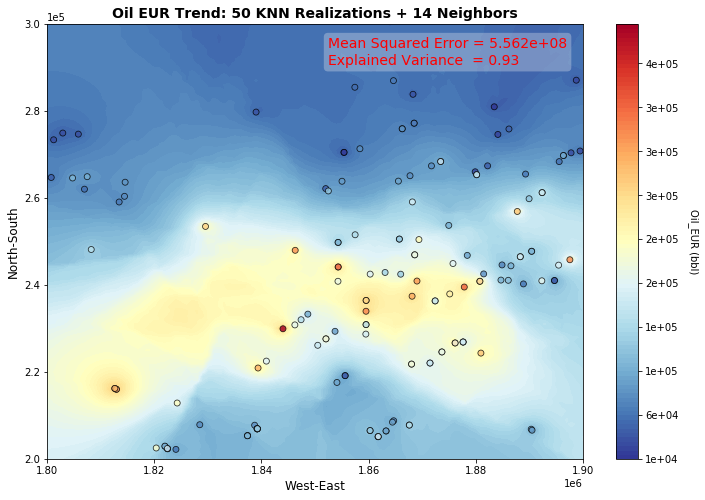

In [7]:
fig, ax1 = plt.subplots(figsize=(12,8))
cmap = plt.cm.RdYlBu_r
cs = ax1.contourf(xx, yy, z1, cmap=cmap,vmin=prodmin, vmax=prodmax, levels=np.linspace(prodmin, prodmax, 100))
cbar = plt.colorbar(cs, orientation = 'vertical',format='%.0e')
ax1.scatter(df[PARA_1], df[PARA_2],s=None,c=df[PARA_3],cmap=cmap,marker=None,
            norm=None,vmin=prodmin, vmax=prodmax,alpha=0.8,linewidths=0.8,
            verts=None, edgecolors='black');

ax1.set_xlabel('West-East',fontsize=12); 
ax1.set_ylabel('North-South',fontsize=12)
ax1.ticklabel_format(style='sci', scilimits=(0,0))
cbar.set_label(PARA_3+' (bbl)', rotation=270, labelpad=20)
ax1.set_title('Oil EUR Trend: %i KNN Realizations + %i Neighbors'%(max_num_bags,num_k),
              fontsize=14,fontweight='bold')
ax1.set_xlim(x_end_low,x_end_up); ax1.set_ylim(y_end_low,y_end_up);
ax1.ticklabel_format(style='sci', scilimits=(0,0))  

predict_val = plot_bag_knn_return_predictions(df,bagging_models1,x,seeds,PARA_3)
MSE = metrics.mean_squared_error(df[PARA_3],predict_val)
Var_Explained = metrics.explained_variance_score(df[PARA_3],predict_val)
text =('Mean Squared Error = %.3e\n\
Explained Variance  = %.2f' %(round(MSE,2),round(Var_Explained,2)))
props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.3, edgecolor='none')        
fig.text(0.45,0.81, text, size=12,bbox=props,fontsize=14,color ='red')

plt.savefig(plot_path+'03_Krig_Oil_KNN_Map_2.png', dpi=300,bbox_inches='tight')

## Simple Krigging

In [8]:
import geostatspy.GSLIB as GSLIB       
import geostatspy.geostats as geostats

In [9]:
df = pd.read_csv(data_path+"02_Kriging_Oil.csv") 

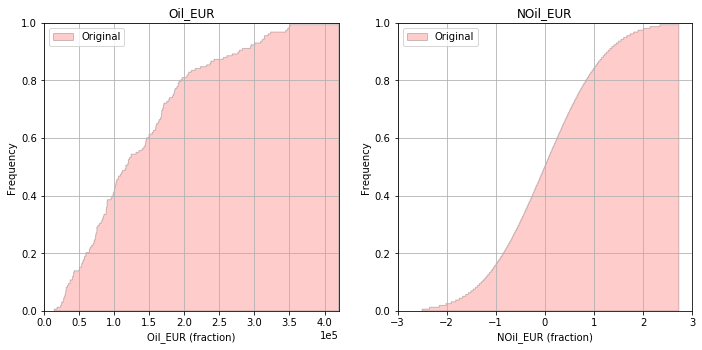

In [10]:
plt.subplot(1,2,1)
plt.hist(df['Oil_EUR'], facecolor='red',bins=1000,histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0,df['Oil_EUR'].max()]); plt.ylim([0,1.0])
plt.xlabel('Oil_EUR (fraction)'); plt.ylabel('Frequency'); plt.title('Oil_EUR')
plt.legend(loc='upper left')
plt.grid(True)
plt.ticklabel_format(style='sci', scilimits=(0,0))

geostats.nscore
df['NOil_EUR'], tvPor, tnsPor = geostats.nscore(df, 'Oil_EUR') 
plt.subplot(1,2,2)
plt.hist(df['NOil_EUR'], facecolor='red',bins=1000,histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([-3.0,3.0]); plt.ylim([0,1.0])
plt.xlabel('NOil_EUR (fraction)'); plt.ylabel('Frequency'); plt.title('NOil_EUR')
plt.legend(loc='upper left')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1, wspace=0.2, hspace=0.3)

In [11]:
xmin = xx.min(); xmax = xx.max()
ymin = yy.min(); ymax = yy.max()  

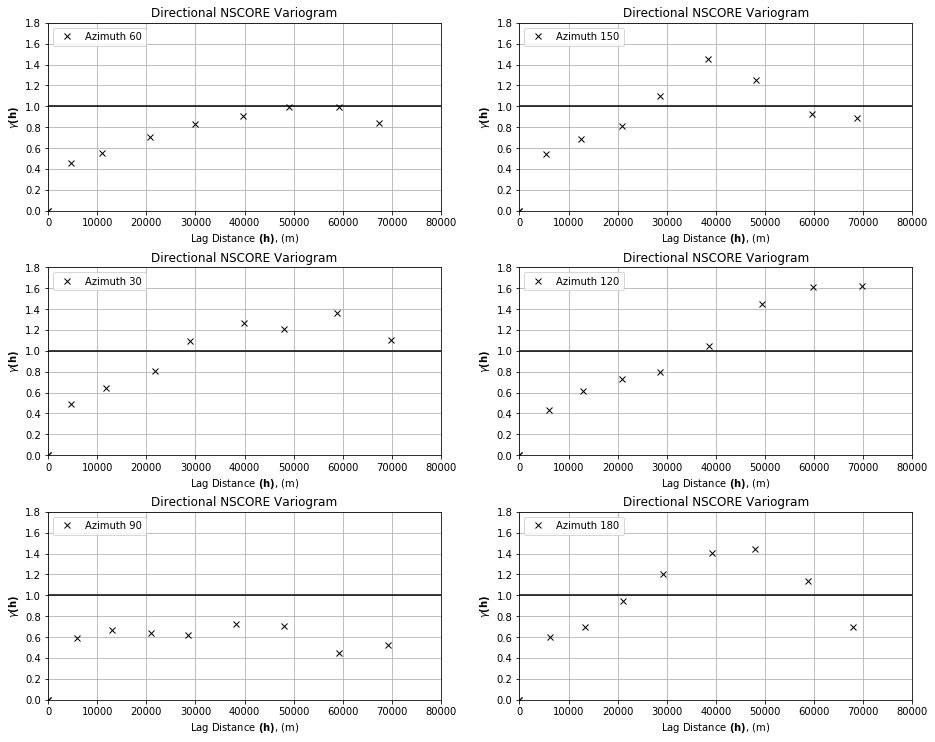

In [12]:
tmin = -1e7; tmax = 1e7                         # no trimming 
lag_dist = 1e4; lag_tol = lag_dist; nlag = 8;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 22.5                             # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [60,60+90,30,30+90,90,180]           # directions in azimuth to consider
# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); 
gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df,"x","y","NOil_EUR",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(4,2,iazi+1)
    plt.plot(lag[iazi,:],gamma[iazi,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,lag_dist*nlag],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional NSCORE Variogram')
    plt.xlim([0,lag_dist*nlag])
    plt.ylim([0,1.8])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.2, wspace=0.2, hspace=0.3)
plt.show()

In [13]:
import math
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    EPSLON = 0.000_000
    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1
    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
                cov1 = pmx - cc[js] * (h ** aa[js])
                cova2_ = cova2_ + cov1
    return cova2_

def vmodel(
    nlag,
    xlag,
    azm,
    vario
):
    """GSLIB's VMODEL program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Mar, 2019).
    :param nlag: number of variogram lags 
    :param xlag: size of the lags
    :param axm: direction by 2D azimuth, 000 is y positive, 090 is x positive 
    :param vario: dictionary with the variogram parameters
    :return:
    """
    
# Parameters
    MAXNST=4
    DEG2RAD=3.14159265/180.0 
    MAXROT=MAXNST+1
    EPSLON = 1.0e-20
    VERSION= 1.01
  
# Declare arrays
    index = np.zeros(nlag+1)
    h = np.zeros(nlag+1)
    gam = np.zeros(nlag+1)
    cov = np.zeros(nlag+1)
    ro = np.zeros(nlag+1)
    
# Load the variogram
    nst = vario["nst"]
    cc = np.zeros(nst)
    aa = np.zeros(nst)
    it = np.zeros(nst)
    ang = np.zeros(nst)
    anis = np.zeros(nst)
    
    c0 = vario["nug"]
    cc[0] = vario["cc1"]
    it[0] = vario["it1"]
    ang[0] = vario["azi1"]
    aa[0] = vario["hmaj1"]
    anis[0] = vario["hmin1"] / vario["hmaj1"]
    if nst == 2:
        cc[1] = vario["cc2"]
        it[1] = vario["it2"]
        ang[1] = vario["azi2"]
        aa[1] = vario["hmaj2"]
        anis[1] = vario["hmin2"] / vario["hmaj2"]
                    
    xoff = math.sin(DEG2RAD*azm)*xlag
    yoff = math.cos(DEG2RAD*azm)*xlag
    print(' x,y,z offsets = ' + str(xoff) + ',' + str(yoff))
    rotmat, maxcov = geostats.setup_rotmat(c0, nst, it, cc, ang, 99999.9)   
          
    
    xx = 0.0; yy = 0.0      
    for il in range(0,nlag+1):
        index[il] = il
        cov[il] = cova2(0.0,0.0,xx,yy,nst,c0,9999.9,cc,aa,it,ang,anis,rotmat,maxcov)
        gam[il] = maxcov - cov[il]
        ro[il]  = cov[il]/maxcov
        h[il]   = math.sqrt(max((xx*xx+yy*yy),0.0))
        xx = xx + xoff
        yy = yy + yoff

# finished
    return index,h,gam,cov,ro

 x,y,z offsets = 3907.3112806704207,9205.04853631667
 x,y,z offsets = 3907.3112806704207,9205.04853631667


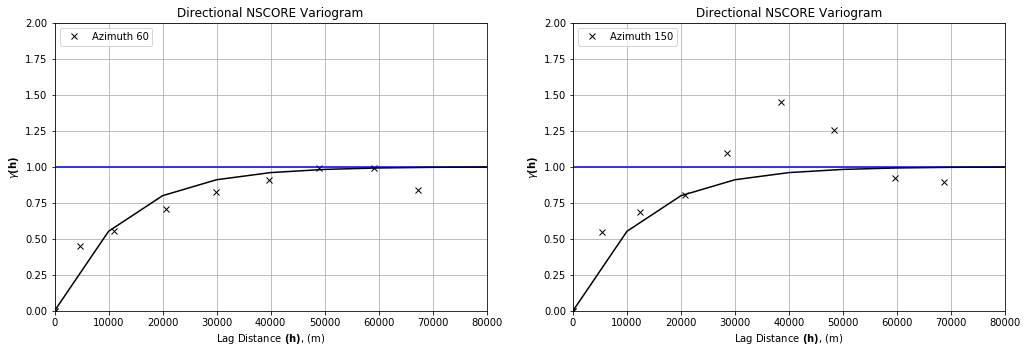

In [14]:
nug = 0; nst = 1
it1 = 2; cc1 = 1; azi1 = 60; hmaj1 = 5e4; hmin1 = 2.8e4
it2 = 2; cc2 = 1-cc1; azi2 = azi1-90; hmaj2 = hmaj1; hmin2 = hmin1
vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2)
nlag = 10; xlag = lag_dist; azm = 23; 
index45,h45,gam45,cov45,ro45 = vmodel(nlag,xlag,azm,vario)
index135,h135,gam135,cov135,ro135 = vmodel(nlag,xlag,azm,vario)
plt.subplot(1,2,1)
plt.plot(lag[0,:],gamma[0,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[0]))
plt.plot([0,1.5e5],[1.0,1.0],color = 'blue')
plt.plot(h45,gam45,color = 'black');
plt.xlim([0,8e4]);
plt.ylim([0,2])
plt.xlabel(r'Lag Distance $\bf(h)$, (m)'); plt.ylabel(r'$\gamma \bf(h)$'); plt.title('Directional NSCORE Variogram'); plt.legend(loc='upper left')
plt.grid()
plt.subplot(1,2,2)
plt.plot(lag[1,:],gamma[1,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[1]))
plt.plot([0,1.5e5],[1.0,1.0],color = 'blue')
plt.plot(h135,gam135,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)'); plt.ylabel(r'$\gamma \bf(h)$'); plt.title('Directional NSCORE Variogram')
plt.legend(loc='upper left');
plt.xlim([0,8e4]);
plt.ylim([0,2])
plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.0, wspace=0.2, hspace=0.3)
plt.savefig(plot_path+'03_Krig_Oil_varigram.png', dpi=300,bbox_inches='tight')

In [15]:
skmean = df['Oil_EUR'].mean();      # simple kriging mean (used if simple kriging is selected below)
ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
radius = 5e4                      # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 20                      # minimum and maximum data for an estimate
tmin = -9e10; tmax = 9e10;                  # minimum property value
nx = 101; ny = 101                      # number of cells
xmn = xmin+500; ymn = ymin+500                        # grid origin, location center of lower left cell
xsiz = 1000; ysiz = 1000                  # cell size

kmap, vmap = geostats.kb2d(df,'x','y','Oil_EUR',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean,vario)

kmap = np.flipud(kmap)

  Estimated   10201 blocks 
      average   136877.2647103731  variance  4688688587.430965


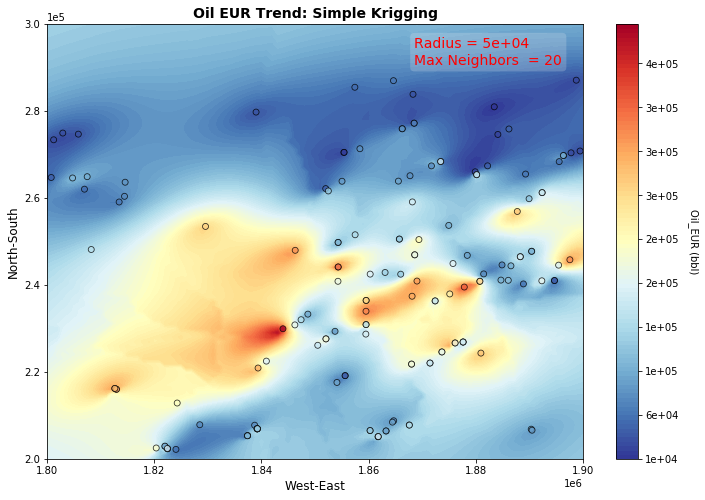

In [16]:
fig, ax1 = plt.subplots(figsize=(12,8))
cmap = plt.cm.RdYlBu_r

cs = ax1.contourf(xx, yy, kmap, cmap=cmap,vmin=prodmin, vmax=prodmax, levels=np.linspace(prodmin, prodmax, 100))
cbar = plt.colorbar(cs, orientation = 'vertical',format='%.0e')

ax1.scatter(df[PARA_1], df[PARA_2],s=None,c=df[PARA_3],cmap=cmap,marker=None,
            norm=None,vmin=prodmin, vmax=prodmax,alpha=0.8,linewidths=0.8,
            verts=None, edgecolors='black');

ax1.set_xlabel('West-East',fontsize=12); 
ax1.set_ylabel('North-South',fontsize=12)
ax1.ticklabel_format(style='sci', scilimits=(0,0))
cbar.set_label(PARA_3+' (bbl)', rotation=270, labelpad=20)
ax1.set_title('Oil EUR Trend: Simple Krigging',
              fontsize=14,fontweight='bold')

text =('Radius = %.0e\n\
Max Neighbors  = %.i' %(radius,ndmax))
props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.2, edgecolor='none')        
fig.text(0.55,0.81, text, size=12,bbox=props,fontsize=14,color ='red')

ax1.set_xlim(x_end_low,x_end_up); ax1.set_ylim(y_end_low,y_end_up);
plt.savefig(plot_path+'03_Krig_Oil_krig_2.png', dpi=300,bbox_inches='tight')

In [17]:
diff = abs(kmap-z1)

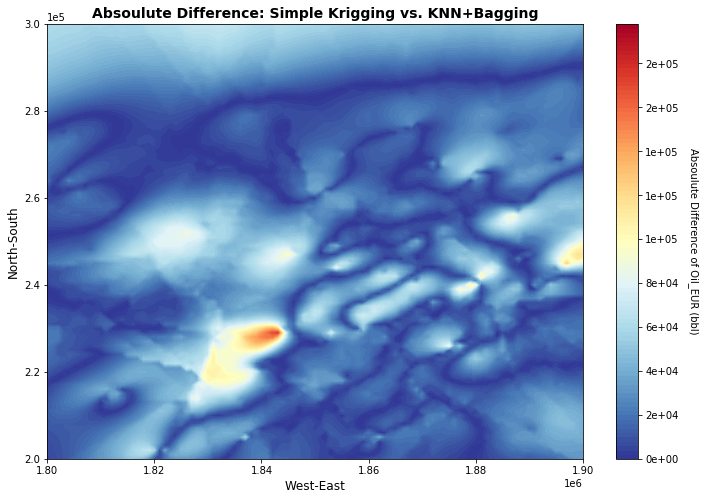

In [18]:
fig, ax1 = plt.subplots(figsize=(12,8))
cmap = plt.cm.RdYlBu_r

cs = ax1.contourf(xx, yy, diff, cmap=cmap,vmin=0, vmax=2e5, levels=np.linspace(0, 2e5, 100))
cbar = plt.colorbar(cs, orientation = 'vertical',format='%.0e')
ax1.set_title('Absoulute Difference: Simple Krigging vs. KNN+Bagging',
              fontsize=14,fontweight='bold')
ax1.ticklabel_format(style='sci', scilimits=(0,0))  
cbar.set_label('Absoulute Difference of '+PARA_3+' (bbl)', rotation=270, labelpad=20)
ax1.set_xlabel('West-East',fontsize=12); 
ax1.set_ylabel('North-South',fontsize=12)
plt.savefig(plot_path+'03_Krig_Oil_diff.png', dpi=300,bbox_inches='tight')

In [1]:
%reset -f